In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import pickle
import dask.dataframe as dd
import seaborn as sns
import numpy as np

from sklearn.metrics import r2_score

/home/tbellagio/.local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
with open('../leave_1_out/splits_samples.pkl', 'rb') as file:
    splits_samples = pickle.load(file)
#train_samples = splits_samples[0][0]
#test_samples = splits_samples[0][1]

In [3]:
## import deltap ld for testing because not ldp will take forever 
delta_ldp = pd.read_csv('/carnegie/nobackup/scratch/xwu/grenet/merged_frequency/merged_hapFIRE_delta_p_LDpruned.txt', 
                        sep = '\t')

In [4]:
clim_sites_during_exp = pd.read_csv('/carnegie/nobackup/scratch/tbellagio/grene/data/bioclimvars_experimental_sites_era5.csv')

In [5]:
forest = RandomForestRegressor(random_state=42, n_estimators = 100, max_depth = None)

In [ ]:
for i in range(100):
    train_samples = splits_samples[i][0]
    test_samples = splits_samples[i][1]

    
    ## traning climate 
    sites_t = pd.Series(train_samples).str.split('_').str[0].astype(int)
    env_t = sites_t.reset_index().merge(clim_sites_during_exp, right_on = 'site', left_on = 0).drop(['index'],axis=1)
    env_t = env_t.drop(0,axis=1)
    mean_env_t = env_t['bio1'].mean()
    std_env_t = env_t['bio1'].std()
    
    env_t['bio1'] = (env_t['bio1'] - mean_env_t) / std_env_t

    ## testing sites
    sites_test = pd.Series(test_samples).str.split('_').str[0].astype(int)
    env_test = sites_test.reset_index().merge(clim_sites_during_exp, right_on = 'site', left_on = 0).drop(['index'],axis=1)
    env_test = env_test.drop(0,axis=1)
    env_test['bio1'] = (env_test['bio1'] - mean_env_t) / std_env_t

    # Define the features and targets
    X_train = np.array(env_t.drop('site',axis=1).copy()['bio1']).reshape(-1, 1)#.reset_index()  # n_env_vars is the number of environmental variables
    #X_train = env.drop('site',axis=1).copy()
    y_train_full = delta_ldp[train_samples].T

    X_test = np.array(env_test.drop('site',axis=1).copy()['bio1']).reshape(-1, 1)

    y_test_full = delta_ldp[test_samples].T

    r2_scores_all = {}
    for snp in y_train_full.columns:
        y_train = y_train_full[snp]
        # Train the model
        forest.fit(X_train, y_train)
        ## evalaute on the training 
        y_predict_train = forest.predict(X_train)
        r2_scores_train = r2_score(y_train, y_predict_train)

        if r2_scores_train > 0.2:
            ##evaluate on the testing 
            y_test = y_test_full[snp]
            y_predict_test = forest.predict(X_test)
            r2_scores_test = r2_score(y_test, y_predict_test)
            r2_scores_all[snp] = [r2_scores_train, r2_scores_test]
    r2_scores_all = pd.DataFrame(r2_scores_all).T.reset_index()
    r2_scores_all.columns = ['snp_index', 'r2train', 'r2test']
    r2_scores_all.to_csv(f'rf_split{1}.csv')

In [53]:
from sklearn.inspection import permutation_importance

In [55]:
forest

RandomForestRegressor(random_state=42)

In [59]:
y_test

4_1_4      0.017409
4_3_1      0.121233
4_3_2      0.009810
4_3_3     -0.169614
4_3_5     -0.216288
             ...   
57_3_12   -0.327012
57_3_13   -0.247929
57_3_15    0.457667
57_3_16   -0.318929
57_3_18   -0.076394
Name: 107, Length: 68, dtype: float64

In [60]:
forest.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [61]:
result = permutation_importance(forest, X_test, y_test, n_repeats=10, random_state=42)

In [62]:
result

{'importances_mean': array([0.04732895]),
 'importances_std': array([0.11891144]),
 'importances': array([[ 0.00940851, -0.01722371,  0.10945597, -0.10705938,  0.2445285 ,
          0.20285786,  0.02180968,  0.05592456, -0.15425268,  0.1078402 ]])}

In [64]:
importance_scores = result.importances_mean

In [65]:
importance_scores

array([0.04732895])

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
X = [[1, 9, 9],[1, 9, 9],[1, 9, 9],
     [0, 9, 9],[0, 9, 9],[0, 9, 9]]
y = [1, 1, 1, 0, 0, 0]
clf = LogisticRegression().fit(X, y)
result = permutation_importance(clf, X, y, n_repeats=10,
                                random_state=0)
result.importances_mean

result.importances_std


array([0.22110832, 0.        , 0.        ])

In [69]:
result.importances_mean.shape

(3,)

In [72]:
X

[[1, 9, 9], [1, 9, 9], [1, 9, 9], [0, 9, 9], [0, 9, 9], [0, 9, 9]]

In [63]:
# Calculate permutation importance after training


# Store or process the importance scores
importance_df = pd.DataFrame(importance_scores, index=env_test.columns, columns=['Importance'])
#importance_df.to_csv(f'feature_importance_split{i}.csv')

ValueError: Shape of passed values is (1, 1), indices imply (20, 1)

In [89]:
af_predictions_split0 = pd.read_csv('af_predictions_split0.csv')

In [90]:
af_predictions_split0

,Unnamed: 0,4_1_4,4_3_1,4_3_2,4_3_3,4_3_5,4_3_6,4_3_7,4_3_8,4_3_9,...,57_3_4,57_3_6,57_3_7,57_3_9,57_3_10,57_3_12,57_3_13,57_3_15,57_3_16,57_3_18
0,19,0.180739,0.180739,0.180739,0.180739,0.180739,0.180739,0.180739,0.180739,0.180739,...,-0.085263,-0.085263,-0.085263,-0.085263,-0.085263,-0.085263,-0.085263,-0.085263,-0.085263,-0.085263
1,45,0.239628,0.239628,0.239628,0.239628,0.239628,0.239628,0.239628,0.239628,0.239628,...,0.034920,0.034920,0.034920,0.034920,0.034920,0.034920,0.034920,0.034920,0.034920,0.034920
2,52,-0.025033,-0.025033,-0.025033,-0.025033,-0.025033,-0.025033,-0.025033,-0.025033,-0.025033,...,0.373334,0.373334,0.373334,0.373334,0.373334,0.373334,0.373334,0.373334,0.373334,0.373334
3,67,-0.240105,-0.240105,-0.240105,-0.240105,-0.240105,-0.240105,-0.240105,-0.240105,-0.240105,...,0.005954,0.005954,0.005954,0.005954,0.005954,0.005954,0.005954,0.005954,0.005954,0.005954
4,172,0.196667,0.196667,0.196667,0.196667,0.196667,0.196667,0.196667,0.196667,0.196667,...,-0.003428,-0.003428,-0.003428,-0.003428,-0.003428,-0.003428,-0.003428,-0.003428,-0.003428,-0.003428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,13878,0.081470,0.081470,0.081470,0.081470,0.081470,0.081470,0.081470,0.081470,0.081470,...,-0.041046,-0.041046,-0.041046,-0.041046,-0.041046,-0.041046,-0.041046,-0.041046,-0.041046,-0.041046
323,13893,0.156091,0.156091,0.156091,0.156091,0.156091,0.156091,0.156091,0.156091,0.156091,...,-0.011712,-0.011712,-0.011712,-0.011712,-0.011712,-0.011712,-0.011712,-0.011712,-0.011712,-0.011712
324,13909,-0.137094,-0.137094,-0.137094,-0.137094,-0.137094,-0.137094,-0.137094,-0.137094,-0.137094,...,0.021135,0.021135,0.021135,0.021135,0.021135,0.021135,0.021135,0.021135,0.021135,0.021135
325,13918,0.138925,0.138925,0.138925,0.138925,0.138925,0.138925,0.138925,0.138925,0.138925,...,0.065077,0.065077,0.065077,0.065077,0.065077,0.065077,0.065077,0.065077,0.065077,0.065077


In [82]:
rf_r2_split0 = pd.read_csv('rf_r2_split0.csv')

In [91]:
rf_r2_split0

,Unnamed: 0,snp_index,r2train,r2test
0,0,19,0.235917,-0.297152
1,1,45,0.290603,0.169631
2,2,52,0.269765,-5.481039
3,3,67,0.200641,-1.309625
4,4,172,0.219324,-0.013152
...,...,...,...,...
322,322,13878,0.211535,-0.067836
323,323,13893,0.215826,-0.094499
324,324,13909,0.247947,0.043288
325,325,13918,0.221855,0.156966


In [83]:
#rf_r2_split0 = rf_r2_split0[rf_r2_split0['r2test'] > 0] 

<Axes: xlabel='r2train', ylabel='r2test'>

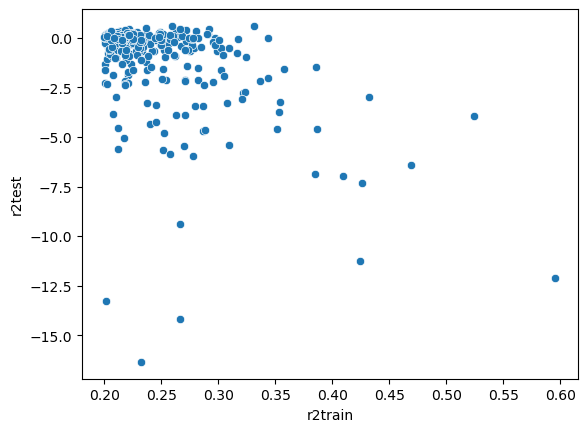

In [84]:
sns.scatterplot(rf_r2_split0, x = 'r2train', y = 'r2test')

In [94]:
with open('../leave_1_out/splits_samples.pkl', 'rb') as file:
    splits_samples = pickle.load(file)
#train_samples = splits_samples[0][0]
#test_samples = splits_samples[0][1]

In [95]:
import subprocess
import random

In [97]:
!pwd

/carnegie/nobackup/scratch/tbellagio/gea_grene-net/gradient_forest


In [106]:
wd = '/carnegie/nobackup/scratch/tbellagio/gea_grene-net/gradient_forest/sh_files/'

In [107]:
file

'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/gradient_forest/split_99.sh'

In [124]:


# Assuming splits_samples is defined elsewhere
shfiles = []
for number, (train_samples, test_samples) in enumerate(splits_samples):
    seed = random.randint(1, 100000000)
    file = wd + f'split_{number}.sh'
    train_samples_str = " ".join(map(str, train_samples))  # map to str in case elements are not strings
    test_samples_str = " ".join(map(str, test_samples)) 
    # Format the commands with proper handling of list conversion to string
    cmd1 = f"python rf_.py {number} '{train_samples_str}' '{test_samples_str}'"
    text = f'''#!/bin/bash
#SBATCH --job-name=split_{number}
#SBATCH --time=5:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=40gb
#SBATCH --cpus-per-task=2
#SBATCH --output=split_{number}_%j.out
#SBATCH --mail-user=tbellagio@carnegiescience.edu
#SBATCH --mail-type=FAIL

source /home/tbellagio/miniforge3/etc/profile.d/conda.sh

export PATH="${{PATH}}:/home/username/bin"

cd /carnegie/nobackup/scratch/gea_grene-net/gradient_forest

conda activate /home/tbellagio/miniforge3/envs/pipeline_snakemake
{cmd1}
'''

    with open(file, 'w') as o:
        o.write(text)
    shfiles.append(file)
    
    # Launch the job



In [125]:
shfiles[0]

'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/gradient_forest/sh_files/split_0.sh'

In [122]:
subprocess.run(['sbatch', shfiles[0]])

Submitted batch job 4985


CompletedProcess(args=['sbatch', '/carnegie/nobackup/scratch/tbellagio/gea_grene-net/gradient_forest/sh_files/split_0.sh'], returncode=0)

In [127]:
for file in shfiles:
    subprocess.run(['sbatch', file])

Submitted batch job 5186
Submitted batch job 5187
Submitted batch job 5188
Submitted batch job 5189
Submitted batch job 5190
Submitted batch job 5191
Submitted batch job 5192
Submitted batch job 5193
Submitted batch job 5194
Submitted batch job 5195
Submitted batch job 5196
Submitted batch job 5197
Submitted batch job 5198
Submitted batch job 5199
Submitted batch job 5200
Submitted batch job 5201
Submitted batch job 5202
Submitted batch job 5203
Submitted batch job 5204
Submitted batch job 5205
Submitted batch job 5206
Submitted batch job 5207
Submitted batch job 5208
Submitted batch job 5209
Submitted batch job 5210
Submitted batch job 5211
Submitted batch job 5212
Submitted batch job 5213
Submitted batch job 5214
Submitted batch job 5215
Submitted batch job 5216
Submitted batch job 5217
Submitted batch job 5218
Submitted batch job 5219
Submitted batch job 5220
Submitted batch job 5221
Submitted batch job 5222
Submitted batch job 5223
Submitted batch job 5224
Submitted batch job 5225


In [ ]:
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    #'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
    'max_depth': [None, 2, 3, 5, 10, 20],  

In [11]:
# Create a random forest regressor object
forest = RandomForestRegressor(random_state=42, n_estimators = 100, max_depth = None)

In [12]:
## import deltap ld for testing because not ldp will take forever 
delta_ldp = pd.read_csv('/carnegie/nobackup/scratch/xwu/grenet/merged_frequency/merged_hapFIRE_delta_p_LDpruned.txt', 
                        sep = '\t', 
                        usecols = train_samples)

clim_sites_during_exp = pd.read_csv('/carnegie/nobackup/scratch/tbellagio/grene/data/bioclimvars_experimental_sites_era5.csv')

sites = pd.Series(train_samples).str.split('_').str[0].astype(int)

env = sites.reset_index().merge(clim_sites_during_exp, right_on = 'site', left_on = 0).drop(['index'],axis=1)
env = env.drop(0,axis=1)
mean_env = env['bio1'].mean()
std_env = env['bio1'].std()

env['bio1'] = (env['bio1'] - mean_env) / std_env

# Load data
#data = pd.read_csv('data.csv')

# Define the features and targets
X_train = np.array(env.drop('site',axis=1).copy()['bio1']).reshape(-1, 1)#.reset_index()  # n_env_vars is the number of environmental variables
#X_train = env.drop('site',axis=1).copy()
y_train_full = delta_ldp.T.copy()

sites_test = pd.Series(test_samples).str.split('_').str[0].astype(int)

env_test = sites_test.reset_index().merge(clim_sites_during_exp, right_on = 'site', left_on = 0).drop(['index'],axis=1)
env_test = env_test.drop(0,axis=1)
#X_test = env_test.drop('site',axis=1).copy()

env_test['bio1'] = (env_test['bio1'] - mean_env) / std_env

X_test = np.array(env_test.drop('site',axis=1).copy()['bio1']).reshape(-1, 1)

## import deltap ld for testing because not ldp will take forever 
delta_ldp_test = pd.read_csv('/carnegie/nobackup/scratch/xwu/grenet/merged_frequency/merged_hapFIRE_delta_p_LDpruned.txt', 
                        sep = '\t', 
                        usecols = test_samples)

y_test_full = delta_ldp_test.T.copy()



-3.1699917298233515e-05
0.07623667112044652
-0.19481082140407846
-0.9027748576011279
-1.1669110884184293
-0.20720257880666582
-0.15777504698964195
-0.07240096115138073
0.04160180608771391
-0.7001714633284406
-0.3187514247721086
-0.12543837676661718
-1.3844902921507325
-0.5589898399717588
-0.23534180527191184
-0.048239008045674936
-4.42202870477308
0.15647865650609172
-2.536514344197652
-2.230110132900699
-0.35738754642612625
-0.3604309486757049
-0.26678375211315397
-0.1665469080320494
-0.4116629680162349
0.022764666053259663
-0.23370292869637965
-0.2607995616590999
-0.14480941120988233
-0.4603197126388885
-0.6243962375836696
-0.3852060578532517
-1.1829249985788515
-0.06901789432822114
-1.4784240601076215
-1.4259076347921078
-0.20833405373137026
-0.02362703985433745
-0.76223851260947
-0.4366189028238523
-0.7931173902422683
-0.37671584134159475
-0.5842535560481961
-0.17508927925573592
-2.319935623069905
-0.09371272123309726
-0.3639991597332508
-0.3086348414761899
-1.5154464922909283



KeyboardInterrupt



In [12]:
r2_scores_train_all = []
r2_scores_test_all = []
for i in y_train_full.columns:
    y_train = y_train_full[i]
    # Create a random forest regressor object
    forest = RandomForestRegressor(n_estimators=100, random_state=42)
    # Train the model
    forest.fit(X_train, y_train)
    ## evalaute on the training 
    y_predict_train = forest.predict(X_train)
    r2_scores_train = r2_score(y_train, y_predict_train, multioutput='raw_values')
    r2_scores_train_all.append(r2_scores_train)
    ##evaluate on the testing 
    y_test = y_test_full[i]
    y_predict_test = forest.predict(X_test)
    r2_scores_test = r2_score(y_test, y_predict_test, multioutput='raw_values')
    r2_scores_test_all.append(r2_scores_test)
    print(r2_scores_test)

[0.00377857]
[0.13329187]
[-0.16030297]
[-0.26167071]
[-0.36972713]
[-0.07421298]
[-0.01514192]
[-0.20898591]
[0.06426335]
[-0.12322189]
[0.01910032]
[-0.11662627]
[-0.21533329]
[-0.09708754]
[0.0861716]
[-0.09159923]
[-0.33708502]
[0.16177826]
[-0.54641617]
[-0.90802349]
[-0.22777768]
[0.03352733]
[0.03712493]
[0.10926764]
[-0.23373455]
[0.25107685]
[0.01444232]
[-0.06550663]
[0.03551885]
[-0.02684924]
[-0.11852108]
[-0.15015615]
[-0.09788779]
[-0.0310877]
[-0.44744946]
[-0.19008998]
[0.05765637]
[0.04887208]
[-0.14260869]
[-0.21683307]
[-0.20633282]
[0.02329572]
[-0.24387703]
[-0.0403401]
[-0.52328584]
[0.14942188]
[-0.20749711]
[-0.10220301]
[-0.21250979]
[0.0276389]
[-0.05379834]
[-0.06994653]
[-0.29589371]
[-0.17513675]
[0.05996433]
[0.00868156]
[0.04619908]
[-0.22263794]
[0.13309357]
[-0.21385542]
[-0.18908652]
[-0.01869784]
[0.06589787]
[0.08554006]
[-0.12175335]
[0.08284508]
[-0.04230793]
[-0.07301937]
[0.04810796]
[-0.0219426]
[-0.18064001]
[0.14961561]
[-0.01057569]
[-0.06859

In [17]:
r2_scores_train_all = pd.Series(np.array(r2_scores_train_all).flatten())

<Axes: ylabel='Count'>

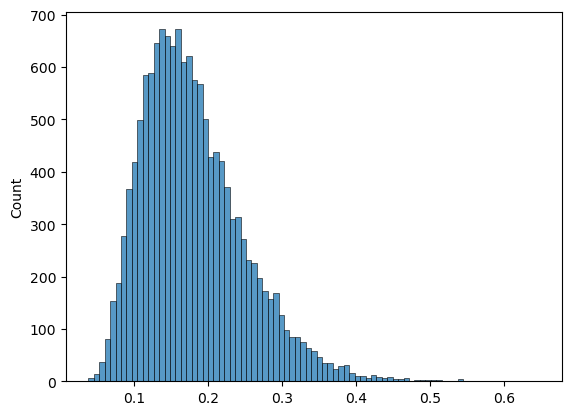

In [18]:
sns.histplot(r2_scores_train_all)

In [19]:
r2_scores_test_all = pd.Series(np.array(r2_scores_test_all).flatten())

In [22]:
r2_scores_test_all.describe()

count    13985.000000
mean        -0.077929
std          0.234907
min        -10.438566
25%         -0.120303
50%         -0.046449
75%          0.012884
max          0.387816
dtype: float64

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, r2_score

param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    #'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
    'max_depth': [None, 2, 3, 5, 10, 20],   # Maximum number of levels in tree
     # Minimum number of samples required at each leaf node
}

# Create a random forest regressor object
forest = RandomForestRegressor(random_state=42)

# Setup the grid search with cross-validation
grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, 
                           scoring='r2', cv=3, verbose=2, n_jobs=-1)

In [63]:
best_forest.

RandomForestRegressor(max_depth=5, n_estimators=200, random_state=42)

In [ ]:
r2_scores_train_all = []
import pandas as pd

r2_scores_train_all = []
r2_scores_test_all = []
best_params_all = []

for i in y_train_full.columns:
    y_train = y_train_full[i]
    y_test = y_test_full[i]
    
    # Fit the grid search
    grid_search.fit(X_train, y_train)
    
    # Best estimator and parameters
    best_forest = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Evaluate on the training set
    y_predict_train = best_forest.predict(X_train)
    r2_score_train = r2_score(y_train, y_predict_train)
    r2_scores_train_all.append(r2_score_train)
    
    # Evaluate on the testing set
    y_predict_test = best_forest.predict(X_test)
    r2_score_test = r2_score(y_test, y_predict_test)
    r2_scores_test_all.append(r2_score_test)
    
    # Collect best parameters and scores for this SNP
    best_params_all.append({'SNP': i, 'Best Parameters': best_params, 'R2 Score Train': r2_score_train, 'R2 Score Test': r2_score_test})
    
    # Print best parameters and R2 score for this SNP
    print(f"Best parameters for SNP {i}: {best_params}")
    print(f"R2 score on test set for SNP {i}: {r2_score_test}")

# Convert the list of dictionaries to a DataFrame
best_params_df = pd.DataFrame(best_params_all)

# Optionally, you can save this DataFrame to a CSV file
best_params_df.to_csv("best_models_per_snp.csv", index=False)


Fitting 3 folds for each of 18 candidates, totalling 54 fits


/home/tbellagio/.local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/tbellagio/.local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Best parameters for SNP 0: {'max_depth': 2, 'n_estimators': 100}
R2 score on test set for SNP 0: -0.00015576982751674961
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters for SNP 1: {'max_depth': 2, 'n_estimators': 100}
R2 score on test set for SNP 1: 0.05692297939891844
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters for SNP 2: {'max_depth': 2, 'n_estimators': 300}
R2 score on test set for SNP 2: 0.00774617126238053
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ...................max_depth=None, n_estimators=100; total time=   0.3s
[CV] END ...................max_depth=None, n_estimators=100; total time=   0.2s
[CV] END ...................max_depth=None, n_estimators=200; total time=   0.5s
[CV] END ...................max_depth=None, n_estimators=300; total time=   0.7s
[CV] END ...................max_depth=None, n_estimators=300; total time=   0.8s
[CV] END ......................max_depth=2, n_estimators=

In [188]:
# Create a random forest regressor object
forest = RandomForestRegressor(n_estimators=500, random_state=42)

# Train the model
forest.fit(X, y)

RandomForestRegressor(n_estimators=500, random_state=42)

In [210]:
tree_depths = [tree.get_depth() for tree in forest.estimators_]
print("Depths of the trees in the forest:", tree_depths)

Depths of the trees in the forest: [7, 10, 7, 8, 9, 9, 8, 9, 10, 10, 7, 10, 8, 10, 8, 9, 9, 8, 8, 8, 8, 7, 8, 9, 8, 9, 8, 11, 8, 8, 8, 9, 8, 9, 8, 9, 9, 10, 9, 10, 9, 8, 11, 10, 8, 8, 8, 9, 9, 8, 10, 9, 7, 8, 8, 9, 8, 8, 9, 9, 8, 9, 8, 9, 7, 8, 9, 9, 10, 9, 8, 8, 11, 8, 7, 11, 9, 9, 8, 9, 7, 10, 9, 9, 9, 10, 9, 9, 8, 10, 8, 8, 8, 7, 7, 7, 10, 10, 7, 8, 8, 10, 10, 9, 9, 8, 8, 9, 9, 8, 10, 9, 7, 8, 8, 8, 7, 7, 8, 7, 7, 10, 9, 8, 9, 9, 9, 8, 8, 8, 10, 10, 8, 8, 9, 8, 8, 8, 9, 10, 9, 9, 9, 9, 9, 8, 9, 9, 8, 11, 7, 9, 10, 10, 9, 8, 8, 9, 9, 9, 9, 8, 8, 7, 9, 9, 7, 8, 11, 9, 7, 8, 10, 8, 9, 8, 9, 9, 8, 7, 9, 8, 9, 9, 8, 9, 8, 9, 8, 7, 9, 8, 9, 9, 9, 8, 10, 9, 8, 8, 8, 8, 9, 8, 10, 9, 8, 9, 9, 8, 8, 8, 10, 7, 8, 9, 7, 9, 9, 9, 8, 9, 8, 10, 10, 8, 9, 9, 9, 8, 7, 8, 8, 8, 9, 8, 7, 9, 10, 8, 10, 9, 9, 8, 9, 10, 8, 10, 7, 10, 10, 9, 8, 9, 10, 8, 9, 7, 8, 8, 8, 10, 9, 9, 9, 9, 8, 8, 9, 8, 9, 10, 10, 9, 10, 9, 8, 10, 9, 8, 9, 9, 8, 8, 10, 10, 9, 8, 8, 11, 7, 9, 8, 9, 9, 8, 9, 8, 7, 7, 9, 9, 8, 9, 7

       Importance
bio15    0.121046
bio7     0.108494
bio2     0.081284
bio14    0.080411
bio3     0.074517
bio8     0.070433
bio4     0.059199
bio6     0.056035
bio16    0.049364
bio19    0.046563
bio12    0.041154
bio17    0.039139
bio5     0.035535
bio9     0.032495
bio13    0.025394
bio10    0.022618
bio1     0.021125
bio11    0.017721
bio18    0.017471


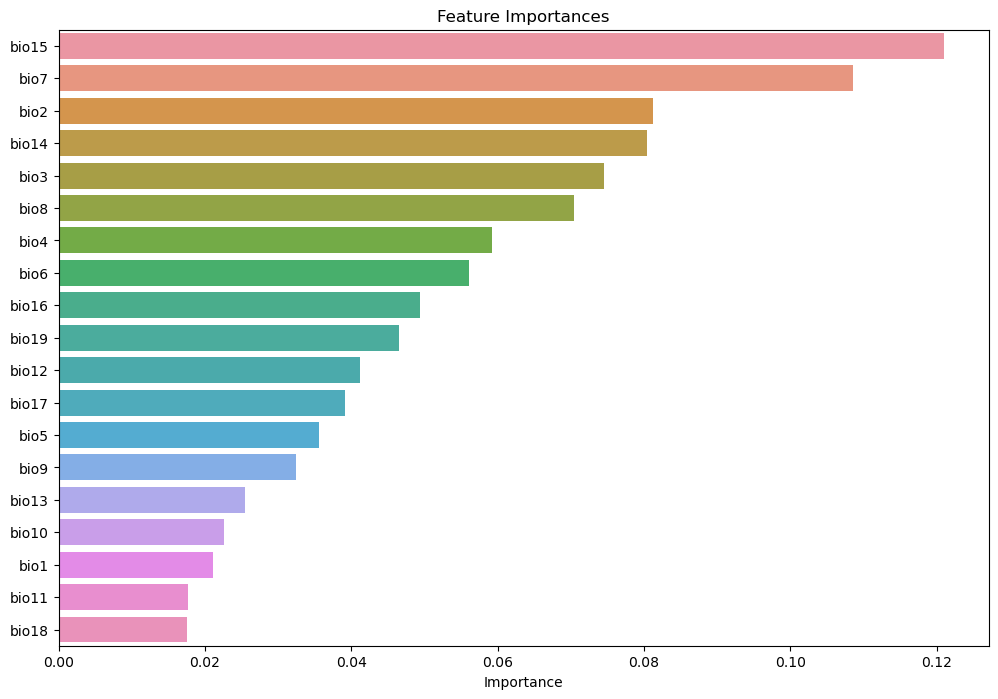

In [209]:
importance = forest.feature_importances_
# Assuming X_train has column names
feature_names = X.columns
feature_importance = pd.DataFrame(importance, index=feature_names, columns=["Importance"])

# Sort features by importance
feature_importance_sorted = feature_importance.sort_values(by="Importance", ascending=False)
print(feature_importance_sorted)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y=feature_importance_sorted.index, data=feature_importance_sorted)
plt.title('Feature Importances')
plt.show()

In [190]:
#env_test['bio1'] = (env_test['bio1'] - mean_env) / std_env

In [193]:
y_predict.shape

(287, 13985)

In [194]:
from sklearn.metrics import r2_score

In [195]:
# Calculate R^2 for each SNP
r2_scores = r2_score(y, y_predict, multioutput='raw_values')
print("R^2 scores for each SNP:", r2_scores)

# Calculate overall R^2
overall_r2 = r2_score(y, y_predict)
print("Overall R^2:", overall_r2)

R^2 scores for each SNP: [0.11437454 0.24114825 0.11452518 ... 0.32078502 0.14595947 0.1216947 ]
Overall R^2: 0.18064479139890824


<Axes: ylabel='Count'>

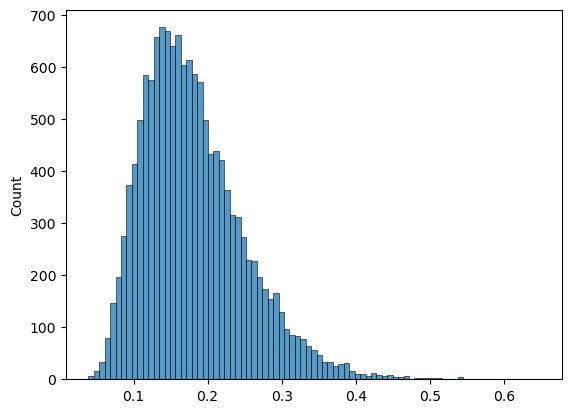

In [196]:
sns.histplot(pd.Series(r2_scores))

In [197]:
mask_rscores = r2_scores > 0.5

In [198]:
mask_rscores.shape

(13985,)

In [199]:
y_sign = y.iloc[:, mask_rscores]

In [200]:
# Create a random forest regressor object
forest = RandomForestRegressor(n_estimators=500, random_state=42)

# Train the model
forest.fit(X, y_sign)

RandomForestRegressor(n_estimators=500, random_state=42)

In [201]:
y_predict2 = forest.predict(X_test)

In [ ]:
## import deltap ld for testing because not ldp will take forever 
delta_ldp_test = pd.read_csv('/carnegie/nobackup/scratch/xwu/grenet/merged_frequency/merged_hapFIRE_delta_p_LDpruned.txt', 
                        sep = '\t', 
                        usecols = test_samples)

y_test = delta_ldp_test.T.copy()

In [204]:
y_test_sign = y_test.iloc[:, mask_rscores]

In [205]:
y_test_sign.shape

(68, 14)

In [206]:
y_predict2.shape

(68, 14)

In [207]:
# Calculate R^2 for each SNP
r2_scores = r2_score(y_test_sign, y_predict2, multioutput='raw_values')
print("R^2 scores for each SNP:", r2_scores)

# Calculate overall R^2
overall_r2 = r2_score(y_test_sign, y_predict2)
print("Overall R^2:", overall_r2)

R^2 scores for each SNP: [-0.72886606 -0.77411021  0.1185532  -0.11568484 -0.02089683  0.09842297
 -0.40803321 -0.36825204 -0.28102286 -0.52748132  0.02126079 -0.09475915
 -0.0760025   0.13646577]
Overall R^2: -0.21574330753176924


<Axes: ylabel='Count'>

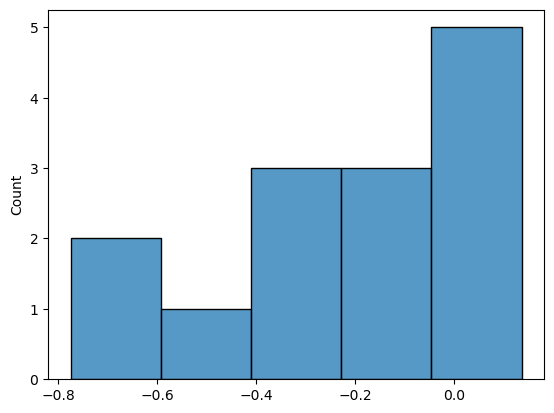

In [208]:
sns.histplot(pd.Series(r2_scores))

In [ ]:
# Make predictions
y_pred = forest.predict(X_test)

# Calculate MSE for each SNP
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
print("MSE for each SNP:", mse)

# Calculate overall MSE
overall_mse = mean_squared_error(y_test, y_pred)
print("Overall MSE:", overall_mse)